In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rawTrain = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
rawDataset = pd.concat([rawTrain, test], axis=0).reset_index(drop=True)
rawDataset["subject"] = "#" + rawDataset["subject"].astype(str)
rawDataset.shape

(10299, 563)

In [3]:
rawDataset.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,#1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,#1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,#1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,#1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,#1,STANDING


In [4]:
print(f"Number of subjects: {rawDataset['subject'].nunique()}")
print(f"Number of activities: {rawDataset['Activity'].nunique()}")

Number of subjects: 30
Number of activities: 6


<BarContainer object of 6 artists>

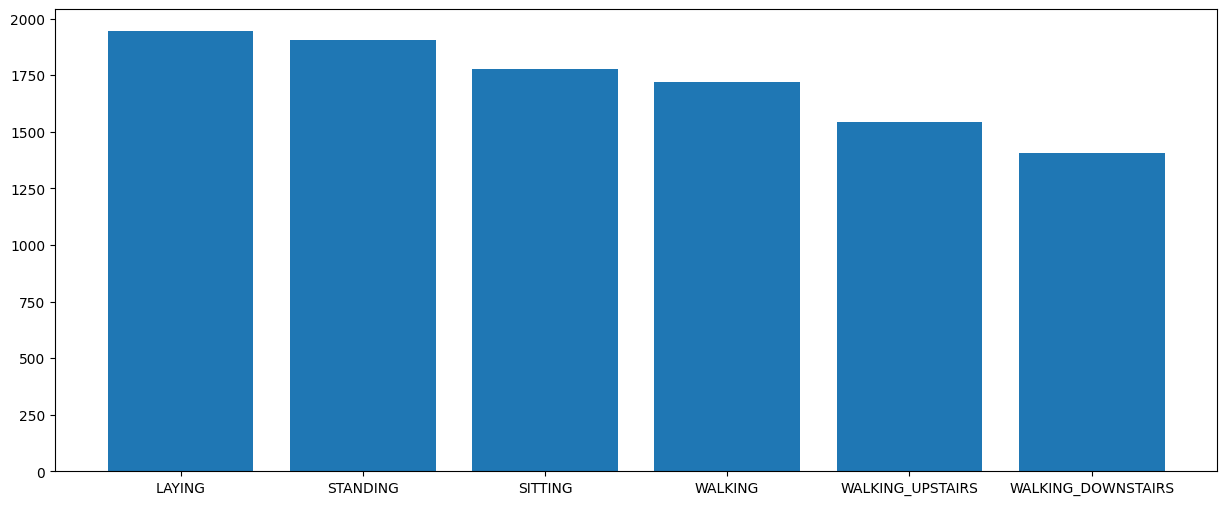

In [5]:
label_counts = rawDataset["Activity"].value_counts()

plt.figure(figsize=(15, 6))
plt.bar(label_counts.index, label_counts)

In [6]:
subject = rawDataset["subject"]
activity = rawDataset["Activity"]
rawTrain = rawDataset.copy()
rawTrain = rawTrain.drop(["subject", "Activity"], axis=1)

In [7]:
# Readying the data by normalizing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def normalizeAndPCA(data):
    scl = StandardScaler()
    stdScaledData = scl.fit_transform(data)
    pca = PCA(n_components=0.9, random_state=0)
    data = pca.fit_transform(stdScaledData)
    return data


train = normalizeAndPCA(rawTrain)
print(train.shape)

(10299, 65)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    train, activity, test_size=0.2, random_state=0
)

First we'll classify this data using k-nearest neighbors algorithm


In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

modelKNN = KNeighborsClassifier(
    n_neighbors=4, weights="distance", algorithm="auto", p=1
)
modelKNN.fit(X_train, Y_train)
Y_predict = modelKNN.predict(X_test)

print(classification_report(Y_test, Y_predict))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       377
           SITTING       0.93      0.91      0.92       364
          STANDING       0.92      0.94      0.93       390
           WALKING       0.96      1.00      0.98       335
WALKING_DOWNSTAIRS       0.99      0.96      0.97       278
  WALKING_UPSTAIRS       1.00      0.98      0.99       316

          accuracy                           0.96      2060
         macro avg       0.96      0.96      0.96      2060
      weighted avg       0.96      0.96      0.96      2060



Now we train a neural network with 3 hidden layers of varyin sizes with the same data

In [10]:
import torch

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_train = torch.tensor(le.fit_transform(Y_train))
Y_test = torch.tensor(le.transform(Y_test))



In [11]:
import torch
import torch.nn as nn

input_size = train.shape[1]
output_size = activity.nunique()

model = nn.Sequential(
    nn.Linear(input_size, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, output_size),
    nn.Softmax(dim=1),
)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch: 0 loss: 1.792632818222046
epoch: 10 loss: 1.7487820386886597
epoch: 20 loss: 1.6651909351348877
epoch: 30 loss: 1.5341657400131226
epoch: 40 loss: 1.370113730430603
epoch: 50 loss: 1.2712074518203735
epoch: 60 loss: 1.221228003501892
epoch: 70 loss: 1.181601881980896
epoch: 80 loss: 1.139103889465332
epoch: 90 loss: 1.1122764348983765
epoch: 100 loss: 1.0997204780578613
epoch: 110 loss: 1.0931167602539062
epoch: 120 loss: 1.088487982749939
epoch: 130 loss: 1.0848302841186523
epoch: 140 loss: 1.081719160079956


Text(0.5, 0, 'epoch')

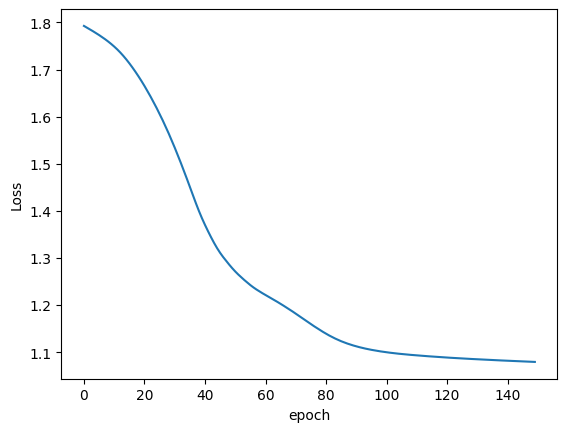

In [12]:
# train the model
epochs = 150
losses = []
for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, Y_train)
    losses.append(loss.item())
    if i % 10 == 0:
        print(f"epoch: {i} loss: {loss.item()}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# plot the loss function
plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("epoch")

In [13]:
from sklearn.metrics import classification_report

with torch.no_grad():
    y_eval = model.forward(X_test)
    loss = criterion(y_eval, Y_test)
print(f"Loss: {loss:.8f}")

with torch.no_grad():
    y_hat = model.forward(X_test)
    predictions = [val.argmax().item() for val in y_hat]


print(classification_report(Y_test, predictions))

Loss: 1.09523702
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       377
           1       0.88      0.91      0.90       364
           2       0.92      0.89      0.90       390
           3       0.97      0.99      0.98       335
           4       0.97      0.96      0.97       278
           5       0.97      0.96      0.97       316

    accuracy                           0.95      2060
   macro avg       0.95      0.95      0.95      2060
weighted avg       0.95      0.95      0.95      2060

